In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [ ]:
# # CUDA 11.1
# !pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0

In [ ]:
# RMSE -> MAE Loss 꿀팁!!

In [3]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('/workspace/sunggu'))
sys.path.append(os.path.abspath('/workspace/sunggu/MONAI'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img/utils'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img/module'))

from sunggu_utils import check_value, take_list, plot_confusion_matrix, list_sort_nicely, find_dir, plot_3D

Thu Sep 23 01:42:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:1B:00.0 Off |                  Off |
| 33%   56C    P2   248W / 260W |  43010MiB / 48601MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:1C:00.0 Off |                  Off |
| 43%   

## Setup imports

In [4]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import skimage
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss
from monai.metrics import compute_meandice, DiceMetric, ConfusionMatrixMetric 
from monai.networks.layers import Norm
from monai.networks.nets import UNet, highresnet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    LoadNumpyd,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    RandFlipd,
    Lambdad,
    ToTensord,
    CastToTyped,
    DeleteItemsd,
    AsDiscrete,
    SpatialPadd,
    CenterSpatialCropd,
    RandSpatialCropd,
    Resized,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0+unknown
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
OS version: Linux (4.15.0-154-generic)
Numpy version: 1.18.5
Pytorch version: 1.8.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.0+cu111
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.54.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set 시드

In [5]:
import random

random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

set_determinism(seed=7)

## Set Train / Test

In [6]:
low_imgs      = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Test/*/20/*/*/*.npy'))
high_imgs     = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Test/*/X/*/*/*.npy'))

dcm_low_imgs  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_DCM/Test/*/20/*/*/*.dcm'))
dcm_high_imgs = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_DCM/Test/*/X/*/*/*.dcm'))

test_files = [{"low": low_name, "high": high_name, "dcm_low" : dcm_low, "dcm_high" : dcm_high} for low_name, high_name, dcm_low, dcm_high in zip(low_imgs, high_imgs, dcm_low_imgs, dcm_high_imgs)]

print("TEST [Total]  number = ", len(low_imgs))

TEST [Total]  number =  859


In [ ]:
# test_low_images  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Test/noise20_b50f_5.0/*/*.npy'))
# test_high_images = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Test/noise100_b50f_5.0/*/*.npy'))

# dcm_test_low_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset_DCM/Test/noise20_b50f_5.0/*/*.dcm"))
# dcm_test_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset_DCM/Test/noise100_b50f_5.0/*/*.dcm"))

# test_files = [{"low": low_name, "high": high_name, "dcm_low" : dcm_low, "dcm_high" : dcm_high} for low_name, high_name, dcm_low, dcm_high in zip(test_low_images,
#                                                                                                                                               test_high_images, 
#                                                                                                                                               dcm_test_low_images, 
#                                                                                                                                               dcm_test_high_images)]

## Augmentation

In [7]:
def MinMax_Normalize(x):
    x -= x.min()
    x /= x.max()
    return x

In [8]:
# CT에 맞는 Augmentation
from torchvision import transforms
test_transforms = Compose(
    [
        LoadNumpyd(keys=["low", "high"]),
        AddChanneld(keys=["low", "high"]), 
        ToTensord(keys=["low", "high"]),
    ]
)

## Check transforms in DataLoader

In [9]:
def visual_windowing_V2(x):
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    
    return x

image shape: torch.Size([512, 512])


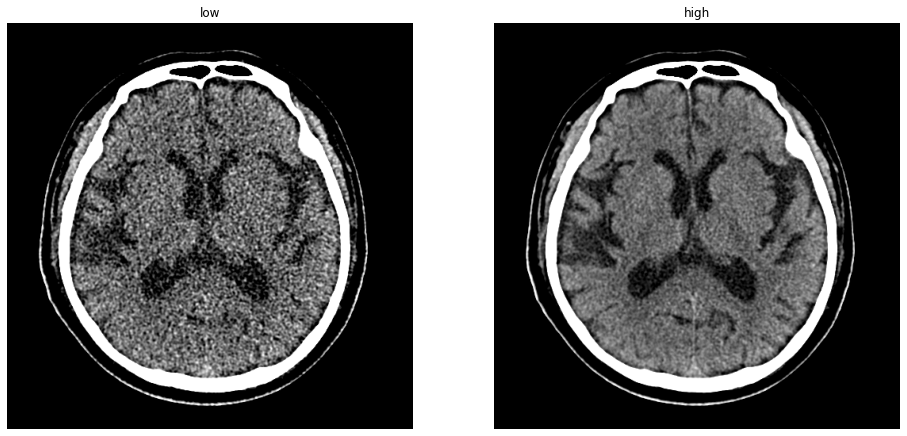

In [10]:
check_ds = Dataset(data=test_files, transform=test_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[142]

n_20 = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {n_20.shape}")

plt.figure("check", (16, 12))

plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing_V2(n_20), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing_V2(high), cmap="gray")
plt.axis('off')

plt.show()

## DataLoader

In [11]:
import multiprocessing
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=8, drop_last=False)

CPU 갯수 =  64


## Create Model, Loss, Optimizer  Only Low -> High

In [12]:
from utils.Unet_sunggu.model import Enhance_hidden_UNet

class Seqeunce_UNet(torch.nn.Module):
    def __init__(self):
        super(Seqeunce_UNet, self).__init__()        
        self.unet = Enhance_hidden_UNet(input_nc=1, output_nc=1)

    def inference(self, noise_20, noise_40, noise_60, noise_80):
        # noise 20이 noise 40보다 더 noise가 심함.
        pred_noise_40, feat_n_40 = self.unet(noise_20, None)
        pred_noise_60, feat_n_60 = self.unet(noise_40, feat_n_40)
        pred_noise_80, feat_n_80 = self.unet(noise_60, feat_n_60)
        pred_high,     feat_high = self.unet(noise_80, feat_n_80)
        
        return pred_noise_40, pred_noise_60, pred_noise_80, pred_high

    def forward(self, noise_20):
        # noise 20이 noise 40보다 더 noise가 심함.
        pred_noise_40, feat_n_40 = self.unet(noise_20, None)
        pred_noise_60, feat_n_60 = self.unet(pred_noise_40, feat_n_40)
        pred_noise_80, feat_n_80 = self.unet(pred_noise_60, feat_n_60)
        pred_high,     feat_high = self.unet(pred_noise_80, feat_n_80)
        
        return pred_noise_40, pred_noise_60, pred_noise_80, pred_high
    
device = 'cuda'
model  = Seqeunce_UNet()      

ImportError: cannot import name 'Enhance_hidden_UNet'

## 모델 이어서 학습하기

In [ ]:
## 네트워크 불러오기
checkpoint_dir = '/workspace/sunggu/4.Dose_img2img/model/[Sequence_Unet]Dose Unet_Teacher_Forcing/epoch_113_model.pth'
checkpoint = torch.load(checkpoint_dir)

model.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch']
print(epoch)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image

## 네트워크 학습시키기
epoch_num = max_epochs
val_interval = 5

writer = SummaryWriter(log_dir='/workspace/sunggu/4.Dose_img2img/runs/[Sequence_Hidden_Unet]Dose Unet_No_teacher')
root_dir = '/workspace/sunggu/4.Dose_img2img/model/[Sequence_Hidden_Unet]Dose Unet_No_teacher/'
low2high_png_dir = '/workspace/sunggu/4.Dose_img2img/Predictions/png/'+'[Sequence_Hidden_Unet]Dose Unet_No_teacher'+'/low2high/'

# 모델 save폴더 만들기
os.makedirs(root_dir, mode=0o777, exist_ok=True)
os.makedirs(low2high_png_dir, mode=0o777, exist_ok=True)

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch}/{epoch_num}")
    
    # Model 선언
    model.train()    
    
    # Loss 선언    
    loss_total_train   = []
    loss_n_40_train    = []
    loss_n_60_train    = []
    loss_n_80_train    = []
    loss_high_train    = []
     
        
    train_iterator = tqdm(train_loader, desc='Train', file=sys.stdout)    
    for batch_data in train_iterator:
        
        input_n_20  = batch_data['n_20'].to(device)
        input_n_40  = batch_data['n_40'].to(device)
        input_n_60  = batch_data['n_60'].to(device)
        input_n_80  = batch_data['n_80'].to(device)
        input_high  = batch_data['high'].to(device)
        
        # Generate fake
#         pred_noise_40, pred_noise_60, pred_noise_80, pred_high, feat_n_40, feat_n_60, feat_n_80, feat_high = model(input_n_20, input_n_40, input_n_60, input_n_80)    
        pred_noise_40, pred_noise_60, pred_noise_80, pred_high = model(input_n_20)    

        optimizer.zero_grad()

        # Loss 
        loss_n_40 = Perceptual_loss(pred_noise_40.repeat(1,3,1,1), input_n_40.repeat(1,3,1,1)) + MS_SSIM_L1_loss(pred_noise_40, input_n_40)
        loss_n_60 = Perceptual_loss(pred_noise_60.repeat(1,3,1,1), input_n_60.repeat(1,3,1,1)) + MS_SSIM_L1_loss(pred_noise_60, input_n_60)
        loss_n_80 = Perceptual_loss(pred_noise_80.repeat(1,3,1,1), input_n_80.repeat(1,3,1,1)) + MS_SSIM_L1_loss(pred_noise_80, input_n_80)
        loss_high = Perceptual_loss(pred_high.repeat(1,3,1,1),     input_high.repeat(1,3,1,1)) + MS_SSIM_L1_loss(pred_high,     input_high)
        
#         Triplet_loss = Triplet_margin_loss(anchor=feat_high, positive=feat_n_80, negative=feat_n_40)+\
#                        Triplet_margin_loss(anchor=feat_high, positive=feat_n_80, negative=feat_n_60)+\
#                        Triplet_margin_loss(anchor=feat_high, positive=feat_n_60, negative=feat_n_40)
#         total_loss = loss_n_40 + loss_n_60 + loss_n_80 + loss_high + Triplet_loss

        total_loss = loss_n_40 + loss_n_60 + loss_n_80 + loss_high
        total_loss.backward()
        optimizer.step()
        
        # 기록        
        loss_total_train  += [total_loss.item()]
        loss_n_40_train   += [loss_n_40.item()]
        loss_n_60_train   += [loss_n_60.item()]
        loss_n_80_train   += [loss_n_80.item()]
        loss_high_train   += [loss_high.item()]
        
        
    print( "Loss       [Total Loss]       = %.4f" %np.mean(loss_total_train) ) 
    print( "Loss       [Noise_40 Loss]    = %.4f" %np.mean(loss_n_40_train) ) 
    print( "Loss       [Noise_60 Loss]    = %.4f" %np.mean(loss_n_60_train) ) 
    print( "Loss       [Noise_80 Loss]    = %.4f" %np.mean(loss_n_80_train) ) 
    print( "Loss       [High Loss]        = %.4f" %np.mean(loss_high_train) ) 
    
    # Tensorboard 저장하기
    input_n_20   = fn_denorm_window(fn_tonumpy((input_n_20)))
    input_n_40   = fn_denorm_window(fn_tonumpy((input_n_40)))
    input_n_60   = fn_denorm_window(fn_tonumpy((input_n_60)))
    input_n_80   = fn_denorm_window(fn_tonumpy((input_n_80)))
    input_high   = fn_denorm_window(fn_tonumpy((input_high)))
    
    pred_noise_40  = fn_denorm_window(fn_tonumpy((pred_noise_40)))
    pred_noise_60  = fn_denorm_window(fn_tonumpy((pred_noise_60)))
    pred_noise_80  = fn_denorm_window(fn_tonumpy((pred_noise_80)))
    pred_high      = fn_denorm_window(fn_tonumpy((pred_high)))

    input_n_20   = np.clip(input_n_20, a_min=0, a_max=1)
    input_n_40   = np.clip(input_n_40, a_min=0, a_max=1)
    input_n_60   = np.clip(input_n_60, a_min=0, a_max=1)
    input_n_80   = np.clip(input_n_80, a_min=0, a_max=1)
    input_high   = np.clip(input_high, a_min=0, a_max=1)
    
    pred_noise_40 = np.clip(pred_noise_40, a_min=0, a_max=1)
    pred_noise_60 = np.clip(pred_noise_60, a_min=0, a_max=1)
    pred_noise_80 = np.clip(pred_noise_80, a_min=0, a_max=1)
    pred_high     = np.clip(pred_high,     a_min=0, a_max=1)

    # png Save
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_n_20.png',   input_n_20[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_n_40.png',   input_n_40[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_n_60.png',   input_n_60[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_n_80.png',   input_n_80[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_high.png',   input_high[0].squeeze(),  cmap="gray")
    
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_pred_noise_40.png', pred_noise_40[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_pred_noise_60.png', pred_noise_60[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_pred_noise_80.png', pred_noise_80[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_pred_high.png',     pred_high[0].squeeze(),      cmap="gray")
   

    # Loss Write
    
    print( "Loss       [Total Loss]       = %.4f" %np.mean(loss_total_train) ) 
    print( "Loss       [Noise_40 Loss]    = %.4f" %np.mean(loss_n_40_train) ) 
    print( "Loss       [Noise_60 Loss]    = %.4f" %np.mean(loss_n_60_train) ) 
    print( "Loss       [Noise_80 Loss]    = %.4f" %np.mean(loss_n_80_train) ) 
    print( "Loss       [High Loss]        = %.4f" %np.mean(loss_high_train) ) 
    
    writer.add_scalar('Train/loss_total',  np.mean(loss_total_train), epoch)
    writer.add_scalar('Train/loss_n_40',   np.mean(loss_n_40_train),  epoch)
    writer.add_scalar('Train/loss_n_60',   np.mean(loss_n_60_train),  epoch)
    writer.add_scalar('Train/loss_n_80',   np.mean(loss_n_80_train),  epoch)
    writer.add_scalar('Train/loss_high',   np.mean(loss_high_train),  epoch)
    
    
    # 저장
    if epoch % 5 == 0 or epoch == epoch_num:

        if torch.cuda.device_count() > 1:
            checkpoint = {'epoch': epoch, 
                          'model_state_dict': model.module.state_dict(), 
                          'optimizer_state_dict': optimizer.state_dict(),
                          'scheduler': scheduler.state_dict(),
                         }                    

        else:
            checkpoint = {'epoch': epoch, 
                          'model_state_dict': model.state_dict(), 
                          'optimizer_state_dict': optimizer.state_dict(),
                          'scheduler': scheduler.state_dict(),
                         }                         

        torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))        
    
        
    # Scheduler
    writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)
    old_lr = optimizer.param_groups[0]['lr']
    lr     = optimizer.param_groups[0]['lr']
    print('Learning Rate %.10f -> %.10f' % (old_lr, lr))
    scheduler.step()     
    
writer.close()    


In [ ]:
if torch.cuda.device_count() > 1:
    checkpoint = {'epoch': epoch, 
                  'model_state_dict': model.module.state_dict(), 
                  'optimizer_state_dict': optimizer.state_dict(),
                  'scheduler': scheduler.state_dict(),
                 }                    

else:
    checkpoint = {'epoch': epoch, 
                  'model_state_dict': model.state_dict(), 
                  'optimizer_state_dict': optimizer.state_dict(),
                  'scheduler': scheduler.state_dict(),
                 }                         

torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))        

## TEST

In [ ]:
#     with torch.no_grad():
#         netG.eval()
#         netD.eval()

#         loss_G_gan_valid  = []
#         loss_G_L1_valid   = []
#         loss_D_real_valid = []
#         loss_D_fake_valid = []
        
#         valid_iterator = tqdm(valid_loader, desc='Valid', file=sys.stdout)    
#         for batch_data in valid_iterator:
        
#             input_low  = batch_data['low'].to(device)
#             input_high = batch_data['high'].to(device)
            
#             output = netG(input_low)

#             real = torch.cat([input_low, input_high], dim=1)
#             fake = torch.cat([input_low, output], dim=1)      
            
#             # D
#             pred_real = netD(real)        
#             pred_fake = netD(fake.detach())

#             loss_D_real = gan_loss(pred_real, torch.ones_like(pred_real))
#             loss_D_fake = gan_loss(pred_fake, torch.zeros_like(pred_fake))

#             # G
#             pred_fake = netD(fake)        
            
#             loss_G_gan = gan_loss(pred_fake, torch.ones_like(pred_fake))
#             loss_G_L1  = L1_loss(output, input_high)

#             # 기록
#             loss_D_real_valid += [loss_D_real.item()]
#             loss_D_fake_valid += [loss_D_fake.item()]
#             loss_G_gan_valid  += [loss_G_gan.item()]
#             loss_G_L1_valid   += [loss_G_L1.item()]
        
        
#     print( "Generator Loss       [Gan Loss]    = %.4f" %np.mean(loss_G_gan_valid) ) 
#     print( "Generator Loss       [L1  Loss]    = %.4f" %np.mean(loss_G_L1_valid) ) 
#     print( "Discriminator Loss   [Real]        = %.4f" %np.mean(loss_D_real_valid) )
#     print( "Discriminator Loss   [Fake]        = %.4f" %np.mean(loss_D_fake_valid) )

    
#     # Tensorboard 저장하기
#     input_low   = fn_denorm(fn_tonumpy((input_low)))
#     input_high  = fn_denorm(fn_tonumpy((input_high)))
#     output = fn_denorm(fn_tonumpy((output)))

#     input_low   = np.clip(input_low, a_min=0, a_max=1)
#     input_high  = np.clip(input_high, a_min=0, a_max=1)
#     output = np.clip(output, a_min=0, a_max=1)

#     # png Save
#     plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_low.png',   input_low[0].squeeze(),   cmap="gray")
#     plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_output_high.png', output[0].squeeze(), cmap="gray")
#     plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_ground_high.png', input_high[0].squeeze(),  cmap="gray")
    
#     # Loss Write    
#     writer.add_scalar('Valid/loss_G_gan',  np.mean(loss_G_gan_valid), epoch)
#     writer.add_scalar('Valid/loss_G_L1',   np.mean(loss_G_L1_valid), epoch)
#     writer.add_scalar('Valid/loss_D_real', np.mean(loss_D_real_valid), epoch)
#     writer.add_scalar('Valid/loss_D_fake', np.mean(loss_D_fake_valid), epoch)

    
#     # 저장
#     if epoch % 5 == 0 or epoch == epoch_num:

#         if torch.cuda.device_count() > 1:
#             checkpoint = {'epoch': epoch, 
#                           'netG_state_dict': netG.module.state_dict(), 
#                           'netD_state_dict': netD.module.state_dict(), 
#                           'optimizer_G_state_dict': optimizer_G.state_dict(),
#                           'optimizer_D_state_dict': optimizer_D.state_dict(),  
#                           'scheduler_G': scheduler_G.state_dict(),
#                           'scheduler_D': scheduler_D.state_dict(),
#                          }                    

#         else:
#             checkpoint = {'epoch': epoch, 
#                           'netG_state_dict': netG.state_dict(), 
#                           'netD_state_dict': netD.state_dict(), 
#                           'optimizer_G_state_dict': optimizer_G.state_dict(),
#                           'optimizer_D_state_dict': optimizer_D.state_dict(),
#                           'scheduler_G': scheduler_G.state_dict(),
#                           'scheduler_D': scheduler_D.state_dict(),
#                          }                         

#             torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))        
    
#     # Scheduler
#     writer.add_scalar('lr', optimizer_G.param_groups[0]['lr'], epoch)      
#     old_lr = optimizer_G.param_groups[0]['lr']
#     lr = optimizer_G.param_groups[0]['lr']
#     print('Learning Rate %.10f -> %.10f' % (old_lr, lr))

#     scheduler_G.step()    
#     scheduler_D.step()    

# writer.close()

In [ ]:
def diagnose_network(net, name='network'):
    """Calculate and print the mean of average absolute(gradients)
    Parameters:
        net (torch network) -- Torch network
        name (str) -- the name of the network
    """
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)